In [1238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from arch import arch_model

In [1239]:
main_df = pd.read_csv("../clean_data/main_df_clean.csv")
main_df["Time"] = main_df["Date"]
main_df["Time"] = main_df["Time"].astype(str)
main_df.set_index("Time",inplace=True)
main_df = main_df.drop(columns=["Date"])
main_df

,Coffee,close,vnd Exchange Rate,hnl Exchange Rate,cop Exchange Rate,brl Exchange Rate,Negative_News_Ratio,idr Exchange Rate,Sugar,Milk,...,Honduras_et0_fao_evapotranspiration_hon,Honduras_temperature_2m_mean_hon,Colombia_et0_fao_evapotranspiration_col,Vietnam_temperature_2m_mean_vn,Vietnam_et0_fao_evapotranspiration_vn,Vietnam_wind_speed_10m_max_vn,Indonesia_temperature_2m_mean_in,Indonesia_et0_fao_evapotranspiration_in,Indonesia_precipitation_sum_in,Honduras_precipitation_sum_hon
Time,,,,,,,,,,,,,,,,,,,,,
01/1990,0.758300,79.99,5479.329529,2.0000,440.08,0.000006,0.158372,1804.850000,0.142000,0.071100,...,3.320075,22.378282,2.884960,21.289052,4.109480,21.893360,25.252577,3.412106,6.867742,1.935484
02/1990,0.840100,93.79,5479.329529,2.0000,451.72,0.000010,0.159264,1809.870000,0.146500,0.074176,...,3.872699,23.166586,2.824487,22.938695,4.699384,19.576097,25.438890,3.518966,8.982143,1.210714
03/1990,0.939600,92.14,5479.329529,4.0000,463.40,0.000016,0.160195,1820.350000,0.153100,0.077182,...,4.214509,23.867664,3.066009,24.077493,5.127649,18.735996,25.706005,3.814265,9.561290,2.361290
04/1990,0.937300,93.73,5479.329529,4.0000,474.62,0.000021,0.161169,1826.050000,0.152400,0.077874,...,4.871768,26.082444,2.559262,25.045932,4.603029,16.039177,26.231305,3.766648,6.286667,3.386667
05/1990,0.920200,94.05,5563.430866,4.2000,485.99,0.000023,0.162188,1831.400000,0.146200,0.087742,...,4.842873,25.555970,2.534520,24.485961,4.032747,13.179221,26.307215,3.583512,5.732258,6.467742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07/2024,2.570987,229.20,24251.560000,24.8582,4036.80,5.541448,0.065923,16261.652826,0.193517,0.242129,...,4.118606,24.569386,3.700725,22.884045,3.154708,19.842825,26.897843,4.220664,3.645161,8.112903
08/2024,2.614377,244.05,24245.850000,24.8826,4062.98,5.552014,0.065906,15793.181818,0.184195,0.244700,...,4.518683,24.659843,3.831915,24.035121,4.171292,14.406041,28.485544,4.954863,1.296774,8.254839
09/2024,2.787605,270.25,24163.540000,24.8381,4191.86,5.540967,0.065879,15341.250000,0.206248,0.251466,...,4.216293,24.876693,4.067470,23.041320,3.153404,17.546168,27.723999,4.434608,6.356667,9.396667


In [1240]:
result = adfuller(main_df["Coffee"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -1.7881037924831735
P-Value: 0.3863836197218491


In [1241]:
main_df["coffee_diff"] = main_df["Coffee"].diff()

main_df["coffee_diff"] = main_df["coffee_diff"].replace([np.inf, -np.inf], np.nan)

main_df = main_df.dropna(subset=["coffee_diff"])

In [1242]:
result = adfuller(main_df["coffee_diff"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -11.585252397836792
P-Value: 2.877944863970424e-21


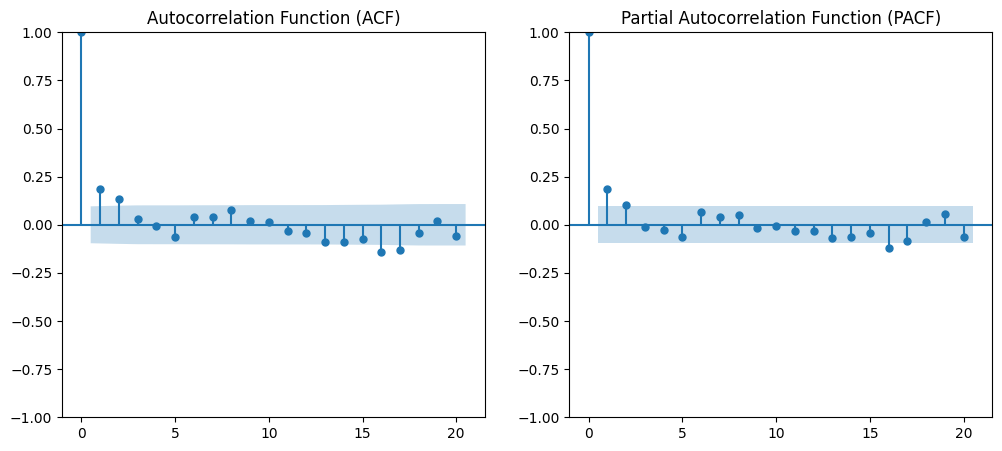

In [1243]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

plot_acf(main_df["coffee_diff"], lags=20, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(main_df["coffee_diff"], lags=20, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

<div align="center">
  ARMA(1,1) Model
</div>

In [1244]:
train_size = int(len(main_df) * 0.8)
train_data = main_df['coffee_diff'][:train_size]
test_data = main_df['coffee_diff'][train_size:]

model = ARIMA(train_data, order=(1, 0, 1))
fitted_model = model.fit()
print(fitted_model.summary())

train_predictions = fitted_model.fittedvalues
test_predictions = fitted_model.forecast(steps=len(test_data))

train_mse = mean_squared_error(train_data[1:], train_predictions[1:])
test_mse = mean_squared_error(test_data, test_predictions)

predicted_returns = np.concatenate([train_predictions, test_predictions])

cumulative_predicted_returns = np.cumsum(predicted_returns)

main_df["coffee_price_change"] = main_df["coffee_diff"].cumsum()

                               SARIMAX Results                                
Dep. Variable:            coffee_diff   No. Observations:                  334
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 277.470
Date:                Wed, 12 Mar 2025   AIC                           -546.940
Time:                        22:13:03   BIC                           -531.696
Sample:                    02-01-1990   HQIC                          -540.862
                         - 11-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.010      0.214      0.830      -0.017       0.021
ar.L1          0.4748      0.121      3.931      0.000       0.238       0.712
ma.L1         -0.2718      0.131     -2.082      0.0

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: 

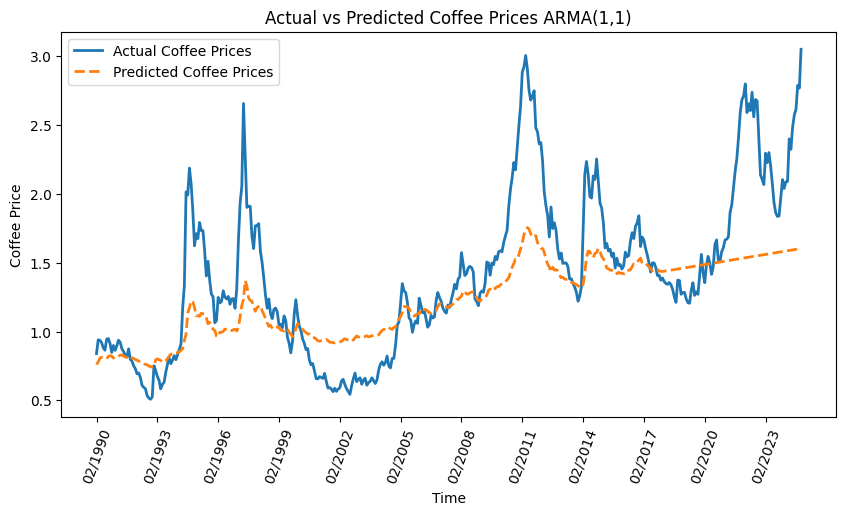

In [1245]:
plt.figure(figsize=(10,5))
plt.plot(main_df.index, main_df["coffee_price_change"] + 0.758300, 
         label="Actual Coffee Prices", linewidth=2)

plt.plot(main_df.index, cumulative_predicted_returns + 0.758300, 
         label="Predicted Coffee Prices", linestyle="dashed", linewidth=2)
plt.legend()

tick_interval = 36
plt.xticks(range(0, len(main_df), tick_interval), rotation=70)

plt.xlabel("Time")
plt.ylabel("Coffee Price")
plt.title("Actual vs Predicted Coffee Prices ARMA(1,1)")

plt.show()

In [1246]:
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 0.011129394845109332
Test MSE: 0.012231949865082914


<div align="center">
  GARCH(1,1) Model
</div>

In [1247]:
train_size = int(len(main_df) * 0.8)
train_returns = main_df['coffee_diff'][:train_size].dropna()
test_returns = main_df['coffee_diff'][train_size:].dropna()

garch_model = arch_model(train_returns, vol="Garch", p=1, q=1)
garch_result = garch_model.fit(disp="off")

train_predicted_volatility = garch_result.conditional_volatility

X_train = sm.add_constant(train_predicted_volatility)
y_train = train_returns

garch_m_reg = sm.OLS(y_train, X_train).fit()
print(garch_m_reg.summary())

train_garch_m_predicted = garch_m_reg.predict(X_train)

test_garch_model = arch_model(test_returns, vol="Garch", p=1, q=1)
test_garch_result = test_garch_model.fit(disp="off")
test_predicted_volatility = test_garch_result.conditional_volatility

X_test = sm.add_constant(test_predicted_volatility)
test_garch_m_predicted = garch_m_reg.predict(X_test)

garch_m_predicted = np.concatenate([train_garch_m_predicted, test_garch_m_predicted])

returns_aligned = pd.concat([train_returns, test_returns])
garch_m_predicted_aligned = pd.Series(garch_m_predicted, index=returns_aligned.index)

train_mse = mean_squared_error(y_train, train_garch_m_predicted)
test_mse = mean_squared_error(test_returns, test_garch_m_predicted)

cumulative_actual = returns_aligned.cumsum()
cumulative_predicted = garch_m_predicted_aligned.cumsum()

                            OLS Regression Results                            
Dep. Variable:            coffee_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1306
Date:                Wed, 12 Mar 2025   Prob (F-statistic):              0.718
Time:                        22:13:03   Log-Likelihood:                 268.87
No. Observations:                 334   AIC:                            -533.7
Df Residuals:                     332   BIC:                            -526.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.012      0.476      0.6

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


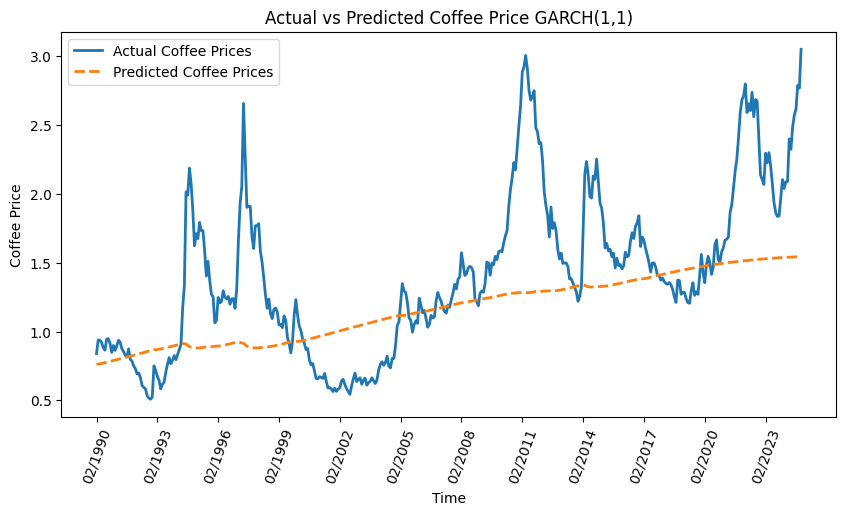

In [1248]:
plt.figure(figsize=(10, 5))

plt.plot(returns_aligned.index, cumulative_actual + 0.758300, 
         label="Actual Coffee Prices", linewidth=2)

plt.plot(returns_aligned.index, cumulative_predicted + 0.758300, 
         label="Predicted Coffee Prices", linestyle="dashed", linewidth=2)

plt.legend()

tick_interval = 36
plt.xticks(range(0, len(returns_aligned), tick_interval), rotation=70)

plt.xlabel("Time")
plt.ylabel("Coffee Price")
plt.title("Actual vs Predicted Coffee Price GARCH(1,1)")

plt.show()

In [1249]:
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 0.011703377137931452
Test MSE: 0.012271830069188635


<div align="center">
  ARDL(1,1) Model
</div>

In [1250]:
for column in main_df.columns:
    if "diff" not in column.lower() and "coffee" not in column.lower():
        new_column_name = column.split()[0][:3] + "_diff" if len(column.split()) > 1 else column[:3] + "_diff"
        
        main_df[new_column_name] = main_df[column].diff()
        
        main_df[new_column_name].dropna(inplace=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_6276\3624867813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df[new_column_name] = main_df[column].diff()
C:\Users\nicol\AppData\Local\Temp\ipykernel_6276\3624867813.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df[new_column_name].dropna(inplace=True)
C:\Users\nicol\AppData\Local\Temp\ipykernel_6276\3624867813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [1251]:
y = main_df["coffee_diff"].dropna()
X = main_df.drop("coffee_diff", axis=1).dropna()

In [1252]:
train_size = int(len(main_df) * 0.8)
train_data = main_df[:train_size].dropna()
test_data = main_df[train_size:].dropna()

X_train = train_data[X.columns]
X_test = test_data[X.columns]

y_train = train_data[y.name]
y_test = test_data[y.name]

lags = 1

X_train_lagged = pd.concat([X_train.shift(i) for i in range(1, lags + 1)], axis=1).dropna()
X_test_lagged = pd.concat([X_test.shift(i) for i in range(1, lags + 1)], axis=1).dropna()

y_train_lagged = y_train.iloc[lags:]
y_test_lagged = y_test.iloc[lags:]

X_lagged = pd.concat([X_train_lagged, X_test_lagged], axis=0)
y_lagged = pd.concat([y_train_lagged, y_test_lagged], axis=0)

X_lagged = sm.add_constant(X_lagged)

model = sm.OLS(y_lagged, X_lagged)
model_fit = model.fit()

print(model_fit.summary())

train_predictions = model_fit.predict(sm.add_constant(X_train_lagged))
test_predictions = model_fit.predict(sm.add_constant(X_test_lagged))

train_mse = mean_squared_error(y_train_lagged, train_predictions)
test_mse = mean_squared_error(y_test_lagged, test_predictions)

predicted_returns = np.concatenate([train_predictions, test_predictions])

returns_aligned = pd.concat([y_train_lagged, y_test_lagged])
predicted_returns_aligned = pd.Series(predicted_returns, index=returns_aligned.index)

cumulative_actual = returns_aligned.cumsum()
cumulative_predicted = predicted_returns_aligned.cumsum()

                            OLS Regression Results                            
Dep. Variable:            coffee_diff   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     6.194
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           1.16e-22
Time:                        22:13:03   Log-Likelihood:                 434.70
No. Observations:                 415   AIC:                            -789.4
Df Residuals:                     375   BIC:                            -628.3
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

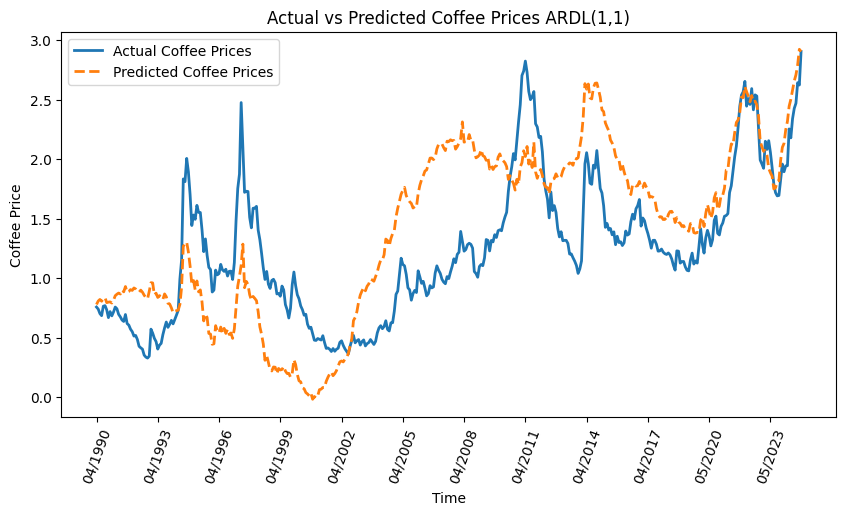

In [1253]:
plt.figure(figsize=(10, 5))

plt.plot(returns_aligned.index, cumulative_actual + 0.758300, 
         label="Actual Coffee Prices", linewidth=2)

plt.plot(returns_aligned.index, cumulative_predicted + 0.758300, 
         label="Predicted Coffee Prices", linestyle="dashed", linewidth=2)

plt.legend()

tick_interval = 36
plt.xticks(range(0, len(returns_aligned), tick_interval), rotation=70)

plt.xlabel("Time")
plt.ylabel("Coffee Price")
plt.title("Actual vs Predicted Coffee Prices ARDL(1,1)")

plt.show()

In [1254]:
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 0.007236707868473125
Test MSE: 0.007083834702386945
